## Introduction

It only takes one toxic comment to sour an online discussion. The Conversation AI team, a research initiative founded by Jigsaw and Google, builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion. If these toxic contributions can be identified, we could have a safer, more collaborative internet.

In the previous 2018 Toxic Comment Classification Challenge, Kagglers built multi-headed models to recognize toxicity and several subtypes of toxicity. In 2019, in the Unintended Bias in Toxicity Classification Challenge, you worked to build toxicity models that operate fairly across a diverse range of conversations. This year, we're taking advantage of Kaggle's new TPU support and challenging you to build multilingual models with English-only training data.

Jigsaw's API, Perspective, serves toxicity models and others in a growing set of languages (see our documentation for the full list). Over the past year, the field has seen impressive multilingual capabilities from the latest model innovations, including few- and zero-shot learning. We're excited to learn whether these results "translate" (pun intended!) to toxicity classification. Your training data will be the English data provided for our previous two competitions and your test data will be Wikipedia talk page comments in several different languages.

As our computing resources and modeling capabilities grow, so does our potential to support healthy conversations across the globe. Develop strategies to build effective multilingual models and you'll help Conversation AI and the entire industry realize that potential.

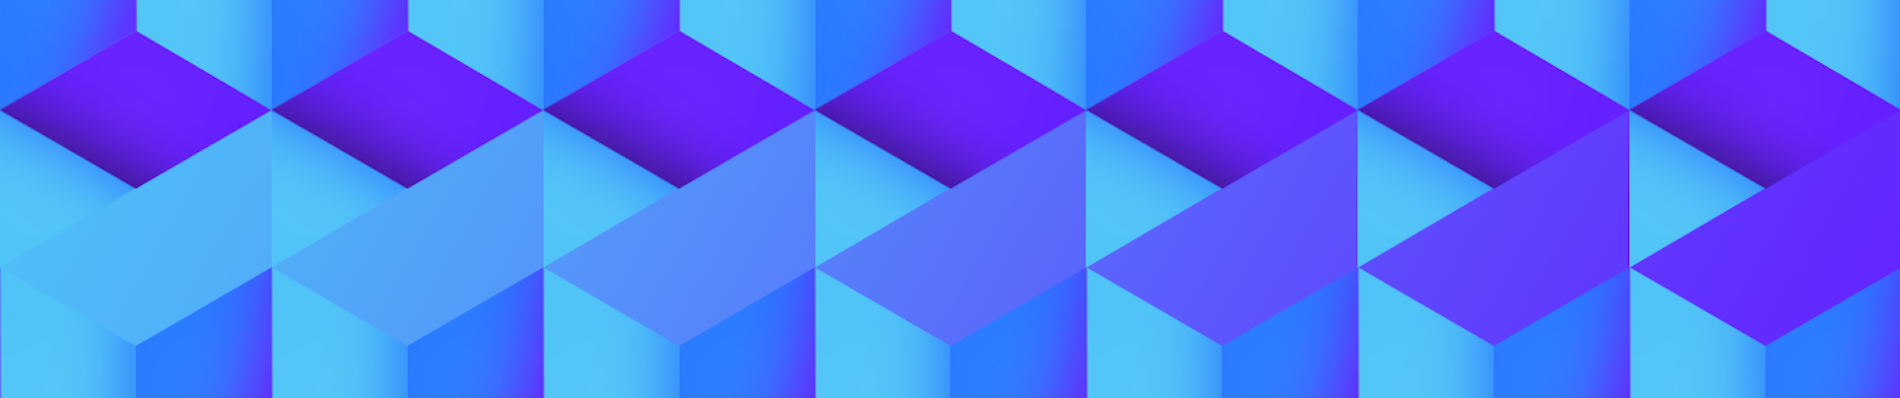


**Note: I will keep updating this notebook during the competition to give insights and share my latest findings and comments. If you like my work, don't hesitate to upvote ;)**

**Sources and credits**: 
- https://www.kaggle.com/shahules/complete-eda-baseline-model-0-708-lb


**Notebooks to get started**:
- https://www.kaggle.com/miklgr500/jigsaw-tpu-bert-two-stage-training
- https://www.kaggle.com/xhlulu/jigsaw-tpu-xlm-roberta
- https://www.kaggle.com/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert
- https://www.kaggle.com/abhishek/inference-of-bert-tpu-model-ml-w-validation

## Loading required packages

In [ ]:
!pip install -q langdetect
!pip install -q textstat

In [ ]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

from collections import defaultdict,Counter
from multiprocessing import Pool

import textstat
from statistics import *

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.express as px
import plotly.offline as py

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from langdetect import detect

from wordcloud import WordCloud, STOPWORDS

from scipy.stats import norm, kurtosis, skew

from tqdm import tqdm
tqdm.pandas() # To have a progress bar using progress_apply

import string, json, nltk, gc

In [ ]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
plt.style.use('seaborn')

In [ ]:
TRAIN_UNINTENDED_BIAS = "../input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv"
TRAIN_TOXICITY = "../input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv"

VALIDATION = "../input/jigsaw-multilingual-toxic-comment-classification/validation.csv"

TEST = "../input/jigsaw-multilingual-toxic-comment-classification/test.csv"

In [ ]:
train_1_df = pd.read_csv(TRAIN_UNINTENDED_BIAS)
train_2_df = pd.read_csv(TRAIN_TOXICITY)

validation_df = pd.read_csv(VALIDATION)

test_df = pd.read_csv(TEST)

You can also see that there are 2 additional training files that contains preprocessed texts for BERT. 
Hint: Since the sentence tokenization process varies from one transformer-based model to another, I recommend doing you own tokenization. For instance, XLM-Roberta and BERT Multilingual don't use the same preprocessing. 

If you want to know more about XLM-Roberta tokenization and preprocessing, check Abhishek Thakur's latest video:
https://www.youtube.com/watch?v=U51ranzJBpY

In [ ]:
train_1_df.head()

In [ ]:
train_2_df.head()

## Exploratory data analysis

### Toxicity distribution

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.countplot(train_1_df['toxic'].astype(int), ax=ax[0])
ax[0].set_title('Unintended bias dataset')

sns.countplot(train_2_df['toxic'].astype(int), ax=ax[1])
ax[1].set_title('Toxicity dataset')

sns.countplot(validation_df['toxic'].astype(int), ax=ax[2])
ax[2].set_title('Validation dataset')

fig.suptitle('Toxicity distribution across datasets', fontweight='bold', fontsize=14)

fig.show()

As expected, the training set is highly imbalanced. 

We note that train unintended bias has continuous toxic values while toxicity training set has categorical values (0 or 1). To come up with such a plot, I assigned a threshold to unintended bias dataset: every toxicity value higher than 0.5 is toxic (1), else 0.

### Language distribution

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(validation_df['lang'], ax=ax[0])
ax[0].set_title('Validation')

sns.countplot(test_df['lang'], ax=ax[1])
ax[1].set_title('Test')

fig.suptitle('Language distribution across datasets', fontweight="bold", fontsize=14)
fig.show()

We need to be careful. The validation set doesn't have samples in all 6 languages on which we are tested in the test set. To build a relevant validation set, we need to add translated sentences in French, Portuguese and Russian to the validation set.

## Length distribution

### Distribution of characters

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

sns.distplot(train_1_df[train_1_df['toxic']==0]['comment_text'].str.len(), axlabel="Non toxic", ax=ax[0])
sns.distplot(train_1_df[train_1_df['toxic']==1]['comment_text'].str.len(), axlabel="Toxic", ax=ax[1])

fig.show()

fig.suptitle("Distribution of number of No: Characters in Comments - Unintended bias dataset", fontsize=14)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

sns.distplot(train_2_df[train_2_df['toxic']==0]['comment_text'].str.len(), axlabel="Non toxic", ax=ax[0])
sns.distplot(train_2_df[train_2_df['toxic']==1]['comment_text'].str.len(), axlabel="Toxic", ax=ax[1])

fig.show()

fig.suptitle("Distribution of number of No: Characters in Comments - Toxicity dataset", fontsize=14)

For the toxicity dataset, we see that comments are much shorter. Let's visualize some tweets which are in the tails (that is above 1000 characters).

In [ ]:
train_1_df[train_1_df['comment_text'].str.len() > 850][['comment_text', 'toxic']].sample(n=100).reset_index(drop=True)

In [ ]:
train_2_df[train_2_df['comment_text'].str.len() > 2000][["comment_text", "toxic"]].sample(n=100).reset_index(drop=True)

As we can see, the text is quite polluted with punctuations and tags such as "\n". We probably want to remove that in a pre-processing phase.

We also note that the unintended bias dataset has much cleaner text than the toxicity dataset... No punctuations or weird tags misplaced. 
We can also note that some comments are just the repetition of some insults over and over again.

Let's see how the text for validation and test is formatted...

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))

sns.distplot(validation_df[validation_df['toxic']==0]['comment_text'].str.len(), axlabel="Validation - Non toxic", ax=ax[0])
sns.distplot(validation_df[validation_df['toxic']==1]['comment_text'].str.len(), axlabel="Validation - Toxic", ax=ax[1])
sns.distplot(test_df['content'].str.len(), axlabel="Test", ax=ax[2])

fig.show()

fig.suptitle("Distribution of number of No: Characters in Comments - Toxicity dataset", fontsize=14)

In [ ]:
validation_df[validation_df['comment_text'].str.len() > 1000][["comment_text", 'lang', "toxic"]].sample(n=100).reset_index(drop=True)

In [ ]:
test_df[test_df['content'].str.len() > 1000][["content", 'lang']].sample(n=100).reset_index(drop=True)

As we can see, validation and test sets are much more nicely formatted than toxicity dataset. We probably don't need to clean that much the unintended bias dataset, but we will need to take care of some punctuations and tags for the toxicity dataset, so that we have a distribution closer to the validation's and test's.

Let's now explore the relationship between language and size of the comments...

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

validation_df["character_count"] = validation_df['comment_text'].apply(lambda x: len(x))
test_df['character_count'] = test_df['content'].apply(lambda x: len(x))

test_df['character_count'] = test_df['character_count'].apply(lambda x: 1000 if x > 1000 else x) # Nicer formatting 

sns.boxplot('lang', 'character_count', data=validation_df, ax=ax[0])
sns.boxplot('lang', 'character_count', data=test_df, ax=ax[1])

fig.show()

fig.suptitle('Distribution of # of characters for each language')

Turkish comments have usually more characters than other languages, while spanish comments are the shortest character-wise. These are pieces of information that we can use to create meta-features in a model.

### Distribution of words

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

sns.distplot(train_1_df[train_1_df['toxic']==0]['comment_text'].str.split().str.len(), axlabel="Non toxic", ax=ax[0])
sns.distplot(train_1_df[train_1_df['toxic']==1]['comment_text'].str.split().str.len(), axlabel="Toxic", ax=ax[1])

fig.show()

fig.suptitle("Distribution of number of No: Words in Comments - Unintended bias", fontsize=14)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

sns.distplot(train_2_df[train_2_df['toxic']==0]['comment_text'].str.split().str.len(), axlabel="Non toxic", ax=ax[0])
sns.distplot(train_2_df[train_2_df['toxic']==1]['comment_text'].str.split().str.len(), axlabel="Toxic", ax=ax[1])

fig.show()

fig.suptitle("Distribution of number of No: Words in Comments - Toxicity", fontsize=14)

Again, we can see that the toxicity dataset have some extremely long comments. 

In [ ]:
def whisker_plot_stats(train):
    ## Number of words 
    train["num_words"] = train["comment_text"].progress_apply(lambda x: len(str(x).split()))

    ## Number of unique words 
    train["num_unique_words"] = train["comment_text"].progress_apply(lambda x: len(set(str(x).split())))

    ## Number of characters 
    train["num_chars"] = train["comment_text"].progress_apply(lambda x: len(str(x)))

    ## Number of stopwords 
    train["num_stopwords"] = train["comment_text"].progress_apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

    ## Number of punctuations 
    train["num_punctuations"] =train['comment_text'].progress_apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

    ## Number of title case words
    train["num_words_upper"] = train["comment_text"].progress_apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

    # Number of title case words
    train["num_words_title"] = train["comment_text"].progress_apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

    # Average length of the words
    train["mean_word_len"] = train["comment_text"].progress_apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    
    return train

In [ ]:
print('Train 1...')
train_1_df = whisker_plot_stats(train_1_df)
print('Train 2...')
train_2_df = whisker_plot_stats(train_2_df)

In [ ]:
train_1_df['num_words'].loc[train_1_df['num_words']>100] = 100
train_1_df['num_punctuations'].loc[train_1_df['num_punctuations']>10] = 10 
train_1_df['num_chars'].loc[train_1_df['num_chars']>350] = 350 
train_1_df['toxic'] = train_1_df['toxic'].apply(lambda x: 1 if x > 0.5 else 0)

train_2_df['num_words'].loc[train_2_df['num_words']>100] = 100
train_2_df['num_punctuations'].loc[train_2_df['num_punctuations']>10] = 10 
train_2_df['num_chars'].loc[train_2_df['num_chars']>350] = 350 


# figure related code
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Distribution of # words in toxicity dataset', fontsize=14, fontweight='bold')

sns.boxplot(x='toxic', y='num_words', data=train_1_df, ax=ax[0])
ax[0].set_title('Unintended bias dataset')

sns.boxplot(x='toxic', y='num_words', data=train_2_df, ax=ax[1])
ax[1].set_title('Toxicity dataset')

fig.show()

In [ ]:
train_1_df[train_1_df['num_words'] >= 100]['comment_text'].sample(n=100).reset_index(drop=True)

In [ ]:
train_2_df[train_2_df['num_words'] >= 100]['comment_text'].sample(n=100).reset_index(drop=True)

### Most common stop words

In [ ]:
def preprocess_comments(df, stop=stop, n=1, col='comment_text'):
    new_corpus=[]
    
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    
    for text in tqdm(df[col], total=len(df)):
        words = [w for w in word_tokenize(text) if (w not in stop)]
       
        words = [lem.lemmatize(w) for w in words if(len(w)>n)]
     
        new_corpus.append(words)
        
    new_corpus = [word for l in new_corpus for word in l]
    
    return new_corpus

In [ ]:
fig,ax = plt.subplots(1, 2, figsize=(15,7))

for i in range(2):
    new = train_1_df[train_1_df['toxic']== i]
    corpus_train = preprocess_comments(new, {})
    
    dic = defaultdict(int)
    for word in corpus_train:
        if word in stop:
            dic[word]+=1
            
    top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x, y = zip(*top)
    ax[i].bar(x,y)
    ax[i].set_title(str(i))

fig.suptitle("Common stopwords in unintented bias dataset")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))

for i in range(2):
    new = train_2_df[train_2_df['toxic']== i]
    corpus_train_2 = preprocess_comments(new, {})
    
    dic = defaultdict(int)
    for word in corpus_train:
        if word in stop:
            dic[word]+=1
            
    top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x, y = zip(*top)
    ax[i].bar(x,y)
    ax[i].set_title(str(i))

fig.suptitle("Common stopwords in toxicity dataset")

### Most common words

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,12))

for i in range(2):
    new = train_2_df[train_2_df['toxic']==i]   
    corpus = corpus_train
    counter = Counter(corpus)
    most = counter.most_common()
    x = []
    y = []
    
    for word,count in most[:20]:
        if (word not in stop) :
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y, y=x, ax=ax[i])
    ax[i].set_title(str(i))
    
fig.suptitle("Common words in toxicity dataset")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,12))

for i in range(2):
    new = train_2_df[train_2_df['toxic']==i]   
    corpus = corpus_train_2
    counter = Counter(corpus)
    most = counter.most_common()
    x = []
    y = []
    
    for word,count in most[:20]:
        if (word not in stop) :
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y, y=x, ax=ax[i])
    ax[i].set_title(str(i))
    
fig.suptitle("Common words in unintended bias dataset")

As expected, insults are the most common words in toxic comments...

### Most common bi-grams

In [ ]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n),stop_words=stop).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

for i in range(2):
    new = train_1_df[train_1_df['toxic'] == i]['comment_text']
    top_n_bigrams = get_top_ngram(new, 2)[:20]
    x, y = map(list, zip(*top_n_bigrams))
    sns.barplot(x=y, y=x, ax=ax[i])
    ax[i].set_title(str(i))
    
fig.suptitle('Common bigrams in unintended bias dataset')

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,10))

for i in range(2):
    new = train_2_df[train_2_df['toxic'] == i]['comment_text']
    top_n_bigrams = get_top_ngram(new, 2)[:20]
    x, y = map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x,ax=ax[i])
    ax[i].set_title(str(i))
    
fig.suptitle("Common bigrams in toxicity dataset")

### Wordcloud

In [ ]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None,ax=None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1 
        )
    
    wordcloud = wordcloud.generate(str(data))
    ax.imshow(wordcloud,interpolation='nearest')
    ax.axis('off')

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,12))

for i in range(2):
    new = train_2_df[train_2_df['toxic'] == i]['comment_text']
    show_wordcloud(new, ax=ax[i])
    ax[i].set_title(str(i))
    
fig.suptitle('Wordcloud for toxicity dataset')

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,12))

for i in range(2):
    new = train_1_df[train_1_df['toxic'] == i]['comment_text']
    show_wordcloud(new, ax=ax[i])
    ax[i].set_title(str(i))
    
fig.suptitle('Wordcloud for unintended bias dataset')

As in the Unintended bias competition, we notice that some ethnicities are targeted and more subject to racial hatred. It was the goal of the previous Jigsaw competition and we will need to make sure we don't create bias in our models.

### Readability index

Full credits to shahules for this very interesting feature:
https://www.kaggle.com/shahules/complete-eda-baseline-model-0-708-lb

Quote from shahules' EDA, go check it out ;)

Readability is the ease with which a reader can understand a written text. In natural language processing, the readability of text depends on its content. It focuses on the words we choose, and how we put them into sentences and paragraphs for the readers to comprehend. 9.1 The Flesch Reading Ease formula

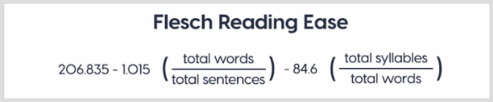

In the Flesch reading-ease test, higher scores indicate material that is easier to read; lower numbers mark passages that are more difficult to read. The formula for the Flesch reading-ease score (FRES) test is<br/><br/>
90-100 - Very Easy<br/>
80-89 - Easy<br/>
70-79 - Fairly Easy<br/>
60-69 - Standard<br/>
50-59 - Fairly Difficult<br/>
30-49 - Difficult<br/>
0-29 - Very Confusing<br/>

In [ ]:
def plot_readability(a, b, title, bins=0.4):
    
    # Setting limits
    a = a[a >= 0]
    a = a[a <= 100]
    b = b[b >= 0]
    b = b[b <= 100]
    
    trace1 = ff.create_distplot([a, b], ['non toxic', 'toxic'], bin_size=bins, show_rug=False)
    trace1['layout'].update(title=title)
    
    py.iplot(trace1, filename='Distplot')
    
    table_data= [["Statistical Measures","non toxic",'toxic'],
                 ["Mean",mean(a),mean(b)],
                 ["Standard Deviation",pstdev(a),pstdev(b)],
                 ["Variance",pvariance(a),pvariance(b)],
                 ["Median",median(a),median(b)],
                 ["Maximum value",max(a),max(b)],
                 ["Minimum value",min(a),min(b)]]
    
    trace2 = ff.create_table(table_data)
    py.iplot(trace2, filename='Table')

In [ ]:
fre_non_toxic = np.array(train_1_df["comment_text"][train_1_df["toxic"].astype(int) == 0].sample(n=150000).apply(textstat.flesch_reading_ease))
fre_toxic = np.array(train_1_df["comment_text"][train_1_df["toxic"].astype(int) == 1].apply(textstat.flesch_reading_ease))

plot_readability(fre_non_toxic, fre_toxic, "Flesch Reading Ease - Unintended bias dataset", 1) 

In [ ]:
fre_non_toxic = np.array(train_2_df['comment_text'][train_2_df['toxic'].astype(int) == 0].apply(textstat.flesch_reading_ease))
fre_toxic = np.array(train_2_df['comment_text'][train_2_df['toxic'].astype(int) == 1].apply(textstat.flesch_reading_ease))

plot_readability(fre_non_toxic, fre_toxic, "Flesch Reading Ease - Toxicity dataset", 1)

In [ ]:
fre_non_toxic = np.array(validation_df['comment_text'][validation_df['toxic'].astype(int) == 0].apply(textstat.flesch_reading_ease))
fre_toxic = np.array(validation_df['comment_text'][validation_df['toxic'].astype(int) == 1].apply(textstat.flesch_reading_ease))

plot_readability(fre_non_toxic, fre_toxic, "Flesch Reading Ease - Validation set", 1)

Toxic comments are more readable. Probably because they are less elaborate... An insult is pretty straight forward actually.

## Baseline BERT model

Work in progress...

You can check:
- https://www.kaggle.com/rftexas/gru-lstm-rnn-101